In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Topic Modeling
- sgm: standard generalized markup language

In [2]:
!pip install gensim

In [3]:
from pathlib import Path
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [4]:
path = "/content/drive/MyDrive/01. Programming/Practical NLP/data/Week 16/reuters"
reuters = Path(path)
reuters

PosixPath('/content/drive/MyDrive/01. Programming/Practical NLP/data/Week 16/reuters')

In [22]:
for path in reuters.glob('reut2-003.sgm'):
  # print(path)
  with path.open() as sgm:
    content = sgm.read()
    soup = BeautifulSoup(content)   # tag를 제거하기 위해서
    for segment in soup.find_all('body'):
      data = segment.text.strip()

len(data)

938340

### preprocessing
- 나의 전처리 함수는 따로 만든다
- gensim

In [23]:
from gensim.parsing.preprocessing import preprocess_string
sent = "REUTER\n\n\n\n 9-MAR-1987 05:05\money-fxinterest"
preprocess_string(sent)

['reuter', 'mar', 'monei', 'fxinterest']

In [ ]:
document = preprocess_string(data)   # 토큰 단위로 리스트로 반환됨
document

### LSI Model
- 모델 만들 떄
- model(a, b, c)
  - a: corpus: (단어, 횟수)
  - b: number of topics(num_topics)
  - c: id2word -> dictionary

In [26]:
from gensim.corpora.dictionary import Dictionary

In [ ]:
dictionary = Dictionary([document])   # document를 리스트로 (document들을 넣어줘야됨)
dictionary.token2id

In [ ]:
dictionary.doc2bow(document)   # 단어의 빈도수

In [133]:
from gensim.models import LsiModel, TfidfModel

num_topics = 3
model = LsiModel([dictionary.doc2bow(document)],   # 주의
                 num_topics=num_topics,
                 id2word=dictionary)

In [34]:
model.print_topics()   # 토픽을 반환해줌 -> 원래는 3개 반환해야 되는데 문서가 작아서 하나만 반환됐다

[(0,
  '0.557*"said" + 0.285*"mln" + 0.253*"dlr" + 0.232*"march" + 0.209*"pct" + 0.206*"mar" + 0.206*"freut" + 0.199*"reuter" + 0.150*"year" + 0.133*"bank"')]

### Evaluation

In [35]:
from gensim.models.coherencemodel import CoherenceModel   # 모델이 얼마나 주제를 일관되게 선택했는지 평가하는 매트릭스

In [36]:
coherence = CoherenceModel(model=model,
                           texts=[document],
                           dictionary=dictionary,
                           coherence='c_v')   # [0, 1]로 점수를 매겨준다. 0.5만 되어도 괜찮은 모델

In [37]:
coherence.get_coherence()

0.34671882930648495

### [실습] 토픽 수를 바꿔가면서 모델의 coherence 스코어를 본다 => scatter plot topic별로 score

In [45]:
# for all sgm files

whole_data = []
for path in reuters.glob('*.sgm'):
  with path.open() as sgm:
    content = sgm.read()
    soup = BeautifulSoup(content)   # tag를 제거하기 위해서
    for segment in soup.find_all('body'):
      data = segment.text.strip()
      whole_data.append(data)

In [166]:
doc_2d = [preprocess_string(doc) for doc in whole_data]
dictionary = Dictionary(doc_2d)

In [162]:
def lsa_modeling(document_list, dictionary, num_topics):
  model = LsiModel([dictionary.doc2bow(document) for document in document_list],
                    num_topics=num_topics,
                    id2word=dictionary)
  return document, dictionary, model

def coherence_score(document, dic, model):
  coherence = CoherenceModel(model=model,
                             texts=document,   # 2d
                             dictionary=dic,
                             coherence='c_v')
  return coherence.get_coherence()


In [186]:
from tqdm.notebook import tqdm

min_topic=8
max_topic=40
threshold=8

score_list = []

for i in tqdm(range(min_topic, max_topic+1, threshold), total=(max_topic-min_topic)//threshold+1):
  # 1. modeling fx
  _, dic, model = lsa_modeling(document_list=doc_2d, dictionary=dictionary, num_topics=i)

  # 2. evaluation fx
  score = coherence_score(doc_2d, dic, model)
  
  print(f"{i} topics: {score}")
  topics = model.print_topics(num_topics=i)
  
  score_list.append(score)

  0%|          | 0/5 [00:00<?, ?it/s]

8 topics: 0.3375052414410725
16 topics: 0.3375052414410725
24 topics: 0.3375052414410725
32 topics: 0.35650926763684054
40 topics: 0.35650926763684054


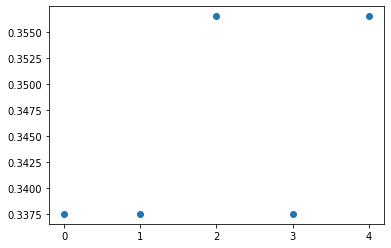

In [183]:
import matplotlib.pyplot as plt
plt.scatter(x=[i for i in range(0, 5)], y=score_list)
plt.xticks([i for i in range(0, 5, 1)])
plt.show()